# Single AI crypto concept

In [1]:
from xdata_config import *

## 1 - Imports and fonctions

In [2]:
from functions_module import *

/usr/local/lib/python3.9/dist-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (
2023-03-19 21:08:27.912983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-19 21:08:27.913392: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-19 21:08:28.276942: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-19 21:08:34.046384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: N

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense 
from keras.models import load_model
from keras.layers import BatchNormalization, Dense

In [ ]:
def mini_expand5(pair="GMT/USDT", i=0, j=10000, window=2, metadata=MetaData,
                 high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                 buy_function=buy_alwase):
    start_index=i
    end_index=j
    window_size=window
    buy_fn=buy_function
    """
    This function takes in several parameters to calculate technical indicators and returns a merged dataframe.
    
    :param pair: str, default "GMT/USDT"
        The trading pair to analyze.
        
    :param start_index: int, default 0
        The start index for selecting data.
        
    :param end_index: int, default 10000
        The end index for selecting data.
    
    :param window_size: int, default 2
        The window size to use for analyzing the data.
    
    :param metadata: MetaData
        The metadata to use for analyzing the data.
    
    :param high_weight: int, default 1
        The weight to use for calculating the high.
    
    :param BUY_PCT: float, default BUY_PCT
        The buy pct to use for analyzing the data.
    
    :param SELL_PCT: float, default SELL_PCT
        The sell pct to use for analyzing the data.
    
    :param buy_fn: function, default buy_min_up
        The buy function to use for analyzing the data.
    
    :return: pd.DataFrame
        A merged dataframe containing the calculated technical indicators.
    """
    print(f"mini_expand : {pair}")
    # Select data
    pair_df = df_list1m[pair].iloc[start_index:end_index]
    btc_df = df_list1m["BTC/USDT"].loc[(pair_df.index[0] - pd.DateOffset(days=window_size+1)).round(freq='1 min'):pair_df.index[-1]+pd.Timedelta(f"{window_size} day")]
    # Calculate technical indicators
    pair_full = full_expand(pair_df, df_list5m[pair], df_list15m[pair], df_list1h[pair], df_list1d[pair], window_size)
    btc_full = full_expand(btc_df, df_list5m["BTC/USDT"], df_list15m["BTC/USDT"], df_list1h["BTC/USDT"], df_list1d["BTC/USDT"], window_size)   
    btc_full = btc_full.add_prefix("BTC_")
    merged = pd.merge(pair_full, btc_full, left_index=True, right_index=True)
    day_expand(merged)
    Meta_expand(merged, metadata, pair)
    merged = buy_fn(merged, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=MAX_FORCAST_SIZE)
    merged["high"] = (merged["open"] + high_weight * merged["high"] + merged["low"] + merged["close"]) / (3 + high_weight)
    merged["BTC_high"] = (merged["BTC_open"] + high_weight * merged["BTC_high"] + merged["BTC_low"] + merged["BTC_close"]) / (3 + high_weight)
    merged.rename(columns={"high":"price"},inplace=True)
    merged.rename(columns={"BTC_high":"BTC_price"},inplace=True)
    merged = merged.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"])
    open_high_low_close_cols = merged.columns.str.contains("open|high|low|close")
    # merged.loc[:, open_high_low_close_cols & merged.columns.str.contains("BTC")] = (
    #     (merged["BTC_price"] - merged.loc[:, open_high_low_close_cols & merged.columns.str.contains("BTC")]) / merged["BTC_price"]
    # )
    # merged.loc[:, open_high_low_close_cols & ~merged.columns.str.contains("BTC")] = (
    #     (merged["price"] - merged.loc[:, open_high_low_close_cols & ~merged.columns.str.contains("BTC")]) / merged["price"]
    # )
    for key in merged.keys():
        if key.find("BTC")!=-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["BTC_price"]-merged[key])/merged["BTC_price"]
        if key.find("BTC")==-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["price"]-merged[key])/merged["price"]

    merged=merged.dropna()
    print(f'######################  mini_expand5 {pair} - shape {merged.shape}  buy mean : {hp(merged.buy.mean())} ############################')
    return merged


## Special list if needed

In [ ]:
Binance_USDT_HALAL.index("ROSE/USDT")

30

In [ ]:
# from datetime import date
# TICKERS = "../Binance-Fast-Trade-Bot/volatile_volume_" + str(date.today()) + ".txt"
# VOLATILE_COINS=[line.strip() for line in open(TICKERS)]
# PAIR_WITH="USDT"
# VOLATILE_USDT_PAIRS=[coin+"/USDT" for coin in VOLATILE_COINS]
# VOLATILE_BUSD_PAIRS=[coin+"/BUSD" for coin in VOLATILE_COINS]
# VOLATILE_USDT_PAIRS

# coins_to_download=''
# for coin in VOLATILE_COINS:
#     coins_to_download=coins_to_download+" "+coin
# f"node database/ddargs.js {coins_to_download} {PAIR_WITH}"

In [ ]:
# coins_to_download=''
# for coin in VOLATILE_COINS:
#     coins_to_download=coins_to_download+" "+coin
# os.system(f"node database/ddargs.js {coins_to_download} {PAIR_WITH}")#node database/ddargs.js ORN BUSD

In [ ]:
# pair_list = find_intersection(VOLATILE_USDT_PAIRS,Binance_USDT_HALAL)
# #tf = '1m'
# oldest_pair = "BTC/USDT"
# if oldest_pair not in pair_list: pair_list.append(oldest_pair)
# df_list1m = {}
# df_list1d = {}
# df_list1h = {}
# df_list5m = {}
# df_list15m = {}


# for pair in pair_list:
#     df = get_historical_from_db(ccxt.binance(), pair, '1m', path="./database/")
#     df_list1m[pair] = df.loc[:]

# for pair in pair_list:
#     df = get_historical_from_db(ccxt.binance(), pair, '1d', path="./database/")
#     df_list1d[pair] = df.loc[:]

# for pair in pair_list:
#     df = get_historical_from_db(ccxt.binance(), pair, '1h', path="./database/")
#     df_list1h[pair] = df.loc[:]

# for pair in pair_list:
#     df = get_historical_from_db(ccxt.binance(), pair, '5m', path="./database/")
#     df_list5m[pair] = df.loc[:]

# for pair in pair_list:
#     df = get_historical_from_db(
#         ccxt.binance(), pair, '15m', path="./database/")
#     df_list15m[pair] = df.loc[:]
# del(df)
# df_list = df_list1m
# prerr("Data load 100% use df_list1d[\"BTC/USDT\"] for exemple to access")



## Checking the import

In [ ]:
# chking import
MetaData

,0,Pair,launch_week_stamp,launch_day_stamp,launch_minute
0,SNMBUSD,SNM/BUSD,1661126400000,1661472000000,2022-08-26 08:00:00
1,BTCUSDT,BTC/USDT,1502668800000,1502928000000,2017-08-17 04:00:00
2,LUNAUSDT,LUNA/USDT,1597622400000,1597968000000,2020-08-21 10:00:00
3,ETHUSDT,ETH/USDT,1502668800000,1502928000000,2017-08-17 04:00:00
4,GMTUSDT,GMT/USDT,1646611200000,1646784000000,2022-03-09 12:00:00
...,...,...,...,...,...
220,XMRBUSD,XMR/BUSD,1582502400000,1582761600000,2020-02-27 11:00:00
221,RENBUSD,REN/BUSD,1632096000000,1632268800000,2021-09-22 12:00:00
222,DFBUSD,DF/BUSD,1607299200000,1607644800000,2020-12-11 10:00:00
223,JASMYBUSD,JASMY/BUSD,1637539200000,1637539200000,2021-11-22 12:00:00


In [ ]:
if BUY_MODE=="BUY_ONLY":
    buy_function=buy_up_only
elif BUY_MODE=="BUY_UP":
    buy_function=buy_up
elif  BUY_MODE=="BUY_DIP":
    buy_function=buy_min_up
elif  BUY_MODE=="AFTER_DEPTH":
    buy_function=buy_after_depth
elif  BUY_MODE=="BUY_UP_CLOSE":
    buy_function=buy_up_close
elif  BUY_MODE=="AFTER_DEPTH_CLOSE":
    buy_function=buy_after_depth_close
elif  BUY_MODE=="BUY_TEST":
    buy_function=buy_test
elif BUY_MODE=="BUY_MIN_CLOSE":
    buy_function=buy_min_close
elif  BUY_MODE=="SELL_TEST":
    buy_function=sell_test
elif  BUY_MODE=="BUY_FIX":
    buy_function=buy_fix
elif  BUY_MODE=="BUY_OPTIMAL":
    buy_function=buy_optimal


try:
    os.mkdir(DATA_DIR, mode = 0o777)
except Exception as e:
    print(e)
print(f"Results dir: {DATA_DIR}")



[Errno 17] File exists: '/UltimeTradingBot/Data/BUY_OPTIMAL'
Results dir: /UltimeTradingBot/Data/BUY_OPTIMAL


In [ ]:
xdf=pd.DataFrame()
count=0
row_numbers=15000
for pair in pair_list:
    if pair != "BTC/USDT" and pair != "EUR/USDT" and pair != "ETH/USDT" :
        print("working on: "+pair ,end=" -->")
        try:
            
            df=mini_expand5(pair=pair,i=0,j=len(df_list1m[pair]),window=WINDOW_SIZE,metadata=MetaData,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,buy_function=buy_function)
            print("df original shape "+str(df.shape))
            print(f"df original shape buy mean : {df.buy.mean()*100}")
            df=df.reset_index()
            try:df.pop("num_index")
            except: pass
            try:df.pop("index")
            except: pass
            try:df.pop("date")
            except: pass
            df=data_shufler(df)            
            #df=data_chooser(df,weight=50,row_numbers=df.buy.sum()*2)
            df=data_chooser50(df,row_numbers=row_numbers)
            gc.collect()
            df=data_cleanup(df)
            df=df.dropna()
            print(pair+f" is processed -- {count}/{len(pair_list)}")
            # print(df.iloc[0:1])
        except Exception as e:
            print(f"error while processing {pair} {count}/{len(pair_list)}")
            print(e)
        xdf=pd.concat([xdf,df],axis=0)
        count+=1
        del(df)
        gc.collect()
df=xdf
del xdf
gc.collect()


working on: SNM/BUSD -->mini_expand : SNM/BUSD
after mark = : 1
optimalbuy buy maximum forcast size=7 at 0.92% of the current price 
Precent Mean: 0.787%
######################  mini_expand5 SNM/BUSD - shape (156489, 287)  buy mean : 0.787 ############################
df original shape (156489, 287)
df original shape buy mean : 0.7872757829623809
SNM/BUSD is processed -- 0/112
working on: LUNA/USDT -->mini_expand : LUNA/USDT
after mark = : 1
optimalbuy buy maximum forcast size=7 at 0.92% of the current price 
Precent Mean: 0.285%
######################  mini_expand5 LUNA/USDT - shape (953805, 287)  buy mean : 0.285 ############################
df original shape (953805, 287)
df original shape buy mean : 0.2850687509501418
LUNA/USDT is processed -- 1/112
working on: GMT/USDT -->mini_expand : GMT/USDT
after mark = : 1
optimalbuy buy maximum forcast size=7 at 0.92% of the current price 
Precent Mean: 0.249%
######################  mini_expand5 GMT/USDT - shape (358605, 287)  buy mean : 0.

0

In [ ]:
df=df.reset_index().drop(columns="num_index")
gc.collect()
for i in range(1):
    df = df.reindex(np.random.permutation(df.index)).reset_index().drop(columns="index")
    gc.collect()
df

,price,high-1,low-1,close-1,volume-1,high-2,low-2,close-2,volume-2,high-3,...,BTC_volume-6_5min,BTC_high-7_5min,BTC_low-7_5min,BTC_close-7_5min,BTC_volume-7_5min,day,hour,minute,lunch_day,buy
0,1.336000,0.000000,0.000000,0.000000,83.20,-0.000749,-0.000749,-0.000749,149.50,0.000000,...,484.14547,0.005987,0.008202,0.007551,367.34044,3,8,22,-597,1
1,2.942000,0.000000,0.000680,0.000000,1859.10,-0.006458,-0.001360,-0.002379,513.60,-0.009517,...,2327.68933,0.000221,0.014053,0.010287,1794.86067,2,2,37,-420,1
2,0.042600,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,...,169.47344,-0.000922,0.000811,0.000335,209.14587,5,3,48,-786,0
3,0.086850,0.000576,0.000576,0.000576,0.00,0.000576,0.000576,0.000576,0.00,0.000576,...,44.43141,0.002454,0.004531,0.002615,55.46427,6,20,45,-314,0
4,0.050738,-0.000049,0.005666,0.000739,1042202.70,0.004090,0.008426,0.005272,238566.20,0.007046,...,87.14242,0.001242,0.003422,0.001313,66.51237,5,22,23,316,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3269995,4.232500,0.002953,0.005316,0.005316,573.79,0.002953,0.005316,0.005316,590.91,0.002953,...,190.90840,-0.003800,-0.002317,-0.002317,127.50173,5,23,58,-355,1
3269996,0.051873,-0.003807,0.000241,0.000048,953549.20,-0.004964,-0.002072,-0.003036,896115.20,-0.003615,...,141.73621,-0.012202,-0.008474,-0.008902,370.41948,1,2,21,316,1
3269997,0.019300,0.000000,0.000000,0.000000,918.20,-0.005181,-0.005181,-0.005181,5223.80,-0.005181,...,3812.98248,-0.015690,-0.008904,-0.009005,2781.25451,3,13,37,-786,1
3269998,6.510000,-0.003072,0.001536,0.001536,1520.04,-0.001536,0.000000,0.000000,1458.12,0.000000,...,245.17035,0.003131,0.005387,0.003919,70.51997,2,0,31,348,1


In [ ]:
df

,price,high-1,low-1,close-1,volume-1,high-2,low-2,close-2,volume-2,high-3,...,BTC_volume-6_5min,BTC_high-7_5min,BTC_low-7_5min,BTC_close-7_5min,BTC_volume-7_5min,day,hour,minute,lunch_day,buy
0,1.336000,0.000000,0.000000,0.000000,83.20,-0.000749,-0.000749,-0.000749,149.50,0.000000,...,484.14547,0.005987,0.008202,0.007551,367.34044,3,8,22,-597,1
1,2.942000,0.000000,0.000680,0.000000,1859.10,-0.006458,-0.001360,-0.002379,513.60,-0.009517,...,2327.68933,0.000221,0.014053,0.010287,1794.86067,2,2,37,-420,1
2,0.042600,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,...,169.47344,-0.000922,0.000811,0.000335,209.14587,5,3,48,-786,0
3,0.086850,0.000576,0.000576,0.000576,0.00,0.000576,0.000576,0.000576,0.00,0.000576,...,44.43141,0.002454,0.004531,0.002615,55.46427,6,20,45,-314,0
4,0.050738,-0.000049,0.005666,0.000739,1042202.70,0.004090,0.008426,0.005272,238566.20,0.007046,...,87.14242,0.001242,0.003422,0.001313,66.51237,5,22,23,316,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3269995,4.232500,0.002953,0.005316,0.005316,573.79,0.002953,0.005316,0.005316,590.91,0.002953,...,190.90840,-0.003800,-0.002317,-0.002317,127.50173,5,23,58,-355,1
3269996,0.051873,-0.003807,0.000241,0.000048,953549.20,-0.004964,-0.002072,-0.003036,896115.20,-0.003615,...,141.73621,-0.012202,-0.008474,-0.008902,370.41948,1,2,21,316,1
3269997,0.019300,0.000000,0.000000,0.000000,918.20,-0.005181,-0.005181,-0.005181,5223.80,-0.005181,...,3812.98248,-0.015690,-0.008904,-0.009005,2781.25451,3,13,37,-786,1
3269998,6.510000,-0.003072,0.001536,0.001536,1520.04,-0.001536,0.000000,0.000000,1458.12,0.000000,...,245.17035,0.003131,0.005387,0.003919,70.51997,2,0,31,348,1


In [ ]:
# df.to_feather(f"../Data/fea/w{WINDOW_SIZE}_buy{BUY_PCT}_forcasr{MAX_FORCAST_SIZE}min_{BUY_MODE}.fea")

In [ ]:
gc.collect()
print("df choosen data shape"+str(df.shape))
print(f"pair: {(df.shape[0]/2)==df.buy.sum()}")
dt=df.to_numpy(dtype=np.float32)
#dt=df.to_numpy()
dt=np.nan_to_num(dt,nan=0)
#dt=dt.astype(np.float32)
dt=np.nan_to_num(dt, neginf=0) 
dt=np.nan_to_num(dt, posinf=0) 

index_20pct= int(0.2*len(dt[:,0]))
print(index_20pct)


df choosen data shape(3270000, 287)
pair: True
654000


In [ ]:
# # feather loading
# df=pd.read_feather(f"../Data/fea/w{WINDOW_SIZE}_buy{BUY_PCT}_forcasr{MAX_FORCAST_SIZE}min_{BUY_MODE}.fea")
# dt=df.to_numpy(dtype=np.float32)
# dt=fixdt(dt)
# index_20pct= int(0.2*len(dt[:,0]))
# gc.collect()



## Self-Normalized Model

In [ ]:

## Normalzed Model
IN_DIM=dt.shape[1]-1
model = Sequential()
model.add(BatchNormalization(input_shape=(IN_DIM,)))
model.add(Dense(int(250),activation='relu')) 
model.add(BatchNormalization())
model.add(Dense(int(20),activation='relu')) 
model.add(Dense(int(50),activation='relu')) 
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
callbacks_a = ModelCheckpoint(filepath =Model_FileName,monitor ='val_accuracy',save_best_only = True, save_weights = True)
callbacks_b = EarlyStopping(monitor ='val_accuracy',mode='auto',patience=15,verbose=1)
print("saving file in: "+Model_FileName)
history = model.fit(dt[index_20pct:, 0:-1],
                dt[index_20pct:,-1],
                validation_data=(dt[:index_20pct, :-1],dt[:index_20pct,-1]),
                epochs=6000,
                batch_size=256*10,
                callbacks=[callbacks_a,callbacks_b])

print('##########################################################################')
print(f"------val_accuracy-----> {'{0:.4g}'.format(max(history.history['val_accuracy'])*100)} | {'{0:.4g}'.format(max(history.history['accuracy'])*100)} <----------accuracy----------")
print(Normalization_File)
print(Model_FileName)
model_init_file=Model_FileName.replace(f"_v{VERSION}", "_vInit")
print(f"save to: {model_init_file}")
model.save(model_init_file)
model_init=model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2023-03-17 11:22:06.494168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-17 11:22:06.496212: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-17 11:22:06.496519: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: abj-K93SV
2023-03-17 11:22:06.496541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: abj-K93SV
2023-03-17 11:22:06.497077: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-03-17 11:22:06.497921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.154.0


 batch_normalization (BatchN  (None, 286)              1144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 250)               71750     
                                                                 
 batch_normalization_1 (Batc  (None, 250)              1000      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 20)                5020      
                                                                 
 dense_2 (Dense)             (None, 50)                1050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,015
Trainable params: 78,943
Non-trainable params: 1,072
__

2023-03-17 11:22:14.526895: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2992704000 exceeds 10% of free system memory.


1022/1022 [==============================] - 53s 51ms/step - loss: 0.3977 - accuracy: 0.8165 - val_loss: 0.3487 - val_accuracy: 0.8419
Epoch 2/6000
1022/1022 [==============================] - 56s 55ms/step - loss: 0.3261 - accuracy: 0.8550 - val_loss: 0.3255 - val_accuracy: 0.8552
Epoch 3/6000
1022/1022 [==============================] - 44s 43ms/step - loss: 0.3064 - accuracy: 0.8652 - val_loss: 0.3189 - val_accuracy: 0.8565
Epoch 4/6000
1022/1022 [==============================] - 44s 43ms/step - loss: 0.2932 - accuracy: 0.8722 - val_loss: 0.3089 - val_accuracy: 0.8679
Epoch 5/6000
1022/1022 [==============================] - 45s 44ms/step - loss: 0.2825 - accuracy: 0.8775 - val_loss: 0.3003 - val_accuracy: 0.8680
Epoch 6/6000
1022/1022 [==============================] - 45s 44ms/step - loss: 0.2742 - accuracy: 0.8819 - val_loss: 0.2891 - val_accuracy: 0.8737
Epoch 7/6000
1022/1022 [==============================] - 52s 51ms/step - loss: 0.2672 - accuracy: 0.8857 - val_loss: 0.2839 

In [ ]:
# model_init_file=Model_FileName.replace(f"_v{VERSION}", "_vInit")
# print(f"save to: {model_init_file}")
# model.save(model_init_file)
# model_init=model

## 2- Model Plus

In [ ]:
import gc
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Define the class weights
class_weights = {0: 1., 1: 1.}

gc.collect()

SizeTunner = 1
IN_DIM = dt.shape[1] - 1

model = Sequential()
model.add(BatchNormalization(input_shape=(IN_DIM,)))
model.add(Dense(int(300 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(200 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(int(20 * SizeTunner), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='val_accuracy', mode='auto', patience=6, verbose=1)
]

print("saving file in: " + Model_FileName)
history = model.fit(dt[index_20pct:, :-1],
                    dt[index_20pct:, -1],
                    validation_data=(dt[:index_20pct, :-1], dt[:index_20pct, -1]),
                    epochs=500,
                    batch_size=256*10,
                    callbacks=callbacks,
                    class_weight=class_weights)

verydeep_model_file=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5"
model.save(verydeep_model_file)
print(verydeep_model_file)
very_deep_model=load_model(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_VeryDeep.h5")
#868/868 [==============================] - 30s 35ms/step - loss: 0.6078 - accuracy: 0.6664 - val_loss: 0.6107 - val_accuracy: 0.6639 >0.6646
#Results after 380 min
# Epoch 133/500
# 347/347 [==============================] - 138s 398ms/step - loss: 0.5867 - accuracy: 0.6842 - val_loss: 0.5839 - val_accuracy: 0.6863
# Epoch 134/500
# 347/347 [==============================] - 137s 395ms/step - loss: 0.5865 - accuracy: 0.6843 - val_loss: 0.5845 - val_accuracy: 0.6861
# Epoch 134: early stopping



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 286)              1144      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 300)               86100     
                                                                 
 batch_normalization_3 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               60200     
                                                                 
 batch_normalization_4 (Batc  (None, 200)             

2023-03-17 12:34:09.260052: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2992704000 exceeds 10% of free system memory.


1022/1022 [==============================] - 165s 157ms/step - loss: 0.4113 - accuracy: 0.8076 - val_loss: 0.3843 - val_accuracy: 0.8263
Epoch 2/500
1022/1022 [==============================] - 157s 153ms/step - loss: 0.3356 - accuracy: 0.8482 - val_loss: 0.3285 - val_accuracy: 0.8474
Epoch 3/500
1022/1022 [==============================] - 157s 154ms/step - loss: 0.3150 - accuracy: 0.8588 - val_loss: 0.3689 - val_accuracy: 0.8428
Epoch 4/500
1022/1022 [==============================] - 156s 153ms/step - loss: 0.3044 - accuracy: 0.8644 - val_loss: 0.2987 - val_accuracy: 0.8653
Epoch 5/500
1022/1022 [==============================] - 158s 154ms/step - loss: 0.2981 - accuracy: 0.8678 - val_loss: 0.2911 - val_accuracy: 0.8708
Epoch 6/500
1022/1022 [==============================] - 157s 153ms/step - loss: 0.2913 - accuracy: 0.8716 - val_loss: 0.2862 - val_accuracy: 0.8738
Epoch 7/500
1022/1022 [==============================] - 157s 154ms/step - loss: 0.2866 - accuracy: 0.8741 - val_loss:

# 3 - Binary Model

In [ ]:
# import gc
# import numpy as np
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Input, Dense, Dropout, BatchNormalization
# from keras.optimizers import Nadam
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model
# from tensorflow.keras.layers.experimental.preprocessing import BinaryQuantization

# # Define the class weights
# class_weights = {0: 1., 1: 1.}

# gc.collect()

# SizeTunner = 1
# IN_DIM = dt.shape[1] - 1

# model = Sequential()

# model.add(BinaryQuantization(input_shape=(IN_DIM,)))

# model.add(Dense(int(300 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dropout(0.2))

# model.add(Dense(int(200 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dense(int(80 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dense(int(80 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dense(int(20 * SizeTunner)))
# model.add(BatchNormalization())
# model.add(BinaryQuantization())
# model.add(Dense(1, activation='sigmoid'))

# print(model.summary())

# optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# callbacks = [
#     ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
#     EarlyStopping(monitor='val_accuracy', mode='auto', patience=6, verbose=1)
# ]

# print("saving file in: " + Model_FileName)
# history = model.fit(dt[index_20pct:, :-1],
#                     dt[index_20pct:, -1],
#                     validation_data=(dt[:index_20pct, :-1], dt[:index_20pct, -1]),
#                     epochs=500,
#                     batch_size=256*10,
#                     callbacks=callbacks,
#                     class_weight=class_weights)
# # Save the model
# binary_model_file=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_BINARY.h5"
# model.save(binary_model_file)
# binary_model_file=tf.keras.models.load_model(binary_model_file)


# Saving the model

In [ ]:
# mini_range_start=0
# mini_range_stop=200000
# model.evaluate(dt[mini_range_start:mini_range_stop,:-1],dt[mini_range_start:mini_range_stop,-1])

## 3-  Test

### stats plus

In [ ]:
USED_MODEL=very_deep_model
#model_init=model
#USED_MODEL=model_init#load_model("/UltimeTradingBot/Data/BUY_UP_CLOSE/tp60_w6_max3min_Model_GoodVeryDeep.h5")
Prediction_Note=USED_MODEL.predict( dt[:, 0:-1])
prediction2=Prediction_Note.round()
hp(prediction2[:,0].mean())
PesemisticPrediction=(Prediction_Note[:,0]-0.49).round()
hp(PesemisticPrediction.mean())
Y=dt[:,-1].copy()
Pred01=prediction2[:,-1]
Original_Traget_Data=Y
Predicted_Data=Pred01

TruePred=((Original_Traget_Data==Predicted_Data)).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")

TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")

LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")

winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)
print(f"========= Win Ratio:{winratio*100} ====================")


2023-03-17 13:34:52.645220: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3740880000 exceeds 10% of free system memory.


102188/102188 [==============================] - 415s 4ms/step
Precent Mean: 57.639%
Precent Mean: 0.476%
ModelAccuracy: 88.813%
True Win Predictions Mean of all: 48.226%
XXX Loss Buy Mean of all: 9.413%
Missed good deal off all: 1.774%
Good Zero prediction Mean: 40.587%
good fiability
========= Win Ratio:83.66904352955464 ====================


## ANTI Retrain 

In [ ]:
# good_dt=dt[TruePred]
# good_dt

In [ ]:
#bad_dt=dt[ np.logical_not(TruePred)]
bad_dt=dt[Predicted_Data==1 ]


In [ ]:
#Anti prediction

BadONE=bad_dt[bad_dt[:,-1]==0]
TrueOne=bad_dt[bad_dt[:,-1]==1][:BadONE.shape[0]]
AntiPrediction_DT=np.concatenate((BadONE,TrueOne),axis=0)
np.random.shuffle(AntiPrediction_DT)

retrain_dt=AntiPrediction_DT
print(f"Dataset Size is : {retrain_dt.shape[0]}")
class_1_weight=hp(retrain_dt[:,-1].mean())/100

import gc
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Define the class weights
index_20pct=int(retrain_dt.shape[1]*0.2)

class_weights = {0: 1-class_1_weight, 1: class_1_weight}

gc.collect()

SizeTunner = 1
IN_DIM = retrain_dt.shape[1] - 1

model = Sequential()
model.add(BatchNormalization(input_shape=(IN_DIM,)))
model.add(Dense(int(200 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(int(80 * SizeTunner), activation='elu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(BatchNormalization())
model.add(Dense(int(80 * SizeTunner), activation='elu'))
model.add(Dense(int(80 * SizeTunner), activation='relu'))
model.add(Dense(int(20 * SizeTunner), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(filepath=Model_FileName, monitor='loss', save_best_only=True, save_weights=True),
    EarlyStopping(monitor='loss', mode='auto', patience=20, verbose=1)
]

print("saving file in: " + Model_FileName)
history = model.fit(retrain_dt[index_20pct:, :-1],
                    retrain_dt[index_20pct:, -1],
                    validation_data=(retrain_dt[:index_20pct, :-1], retrain_dt[:index_20pct, -1]),
                    epochs=500,
                    batch_size=256*5,
                    callbacks=callbacks,
                    class_weight=class_weights)

#868/868 [==============================] - 30s 35ms/step - loss: 0.6078 - accuracy: 0.6664 - val_loss: 0.6107 - val_accuracy: 0.6639 >0.6646
#Results after 380 min
# Epoch 133/500
# 347/347 [==============================] - 138s 398ms/step - loss: 0.5867 - accuracy: 0.6842 - val_loss: 0.5839 - val_accuracy: 0.6863
# Epoch 134/500
# 347/347 [==============================] - 137s 395ms/step - loss: 0.5865 - accuracy: 0.6843 - val_loss: 0.5845 - val_accuracy: 0.6861
# Epoch 134: early stopping
justgood_good_model=model
justgood_good_model_wheretosave=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Anti-Model_v2.h5'
justgood_good_model.save(justgood_good_model_wheretosave)
print(justgood_good_model_wheretosave)

Dataset Size is : 615610
Precent Mean: 50.000%
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_11 (Bat  (None, 286)              1144      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 200)               57400     
                                                                 
 batch_normalization_12 (Bat  (None, 200)              800       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_14 (Dense)            (None, 80)                16080     
                                                                 
 batch_

# True PredONly

In [ ]:
#Change retaindt
for rrr in range(1,7):
    retrain_dt=dt
    class_1_weight=TrueWinPred.mean()

    import gc
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.optimizers import Nadam
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    # Define the class weights
    index_20pct=int(retrain_dt.shape[1]*0.2)
    class_weights = {0: 1-class_1_weight, 1: class_1_weight}
    gc.collect()

    SizeTunner = 1
    IN_DIM = retrain_dt.shape[1] - 1

    model = Sequential()
    model.add(BatchNormalization(input_shape=(IN_DIM,)))
    model.add(Dense(int(200 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # model.add(Dense(int(80 * SizeTunner), activation='elu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))

    # model.add(Dense(int(80 * SizeTunner), activation='elu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))

    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(int(80 * SizeTunner), activation='elu'))
    model.add(Dense(int(80 * SizeTunner), activation='relu'))
    model.add(Dense(int(20 * SizeTunner), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    callbacks = [
        ModelCheckpoint(filepath=Model_FileName, monitor='val_accuracy', save_best_only=True, save_weights=True),
        EarlyStopping(monitor='val_accuracy', mode='auto', patience=16, verbose=1)
    ]

    print("saving file in: " + Model_FileName)
    history = model.fit(retrain_dt[index_20pct:, :-1],
                        TrueWinPred[index_20pct:],
                        validation_data=(retrain_dt[:index_20pct, :-1], TrueWinPred[:index_20pct]),
                        epochs=500,
                        batch_size=256*5,
                        callbacks=callbacks,
                        class_weight=class_weights)

    #868/868 [==============================] - 30s 35ms/step - loss: 0.6078 - accuracy: 0.6664 - val_loss: 0.6107 - val_accuracy: 0.6639 >0.6646
    #Results after 380 min
    # Epoch 133/500
    # 347/347 [==============================] - 138s 398ms/step - loss: 0.5867 - accuracy: 0.6842 - val_loss: 0.5839 - val_accuracy: 0.6863
    # Epoch 134/500
    # 347/347 [==============================] - 137s 395ms/step - loss: 0.5865 - accuracy: 0.6843 - val_loss: 0.5845 - val_accuracy: 0.6861
    # Epoch 134: early stopping

    true_win_model=model
    wheretosave=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+f"_true_win_model_Re{rrr}.h5"
    true_win_model.save(wheretosave)
    print(wheretosave)
    USED_MODEL=true_win_model
    bad_Prediction_Note=USED_MODEL.predict( dt[:, 0:-1])
    Pred02=bad_Prediction_Note.round()
    Original_Traget_Data=Y
    Predicted_Data=Pred02[:,0]

    BadTruePred=(Original_Traget_Data==Predicted_Data).copy()
    BadModelAccuracy=hp(BadTruePred.mean(),"ModelAccuracy")

    BadTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
    BadTrueWinPred_Mean=hp(BadTrueWinPred.mean(),"True Win Predictions Mean of all")

    BadLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
    BadLossPred_Mean=hp(BadLossPred.mean(),"XXX Loss Buy Mean of all")

    BadMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
    BadMissedDeal_Mean=hp(BadMissedDealPred.mean(),"Missed good deal off all")

    BadGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
    BadGoodZero_Mean=hp(BadGoodZeroPred.mean(),"Good Zero prediction Mean")

    fiability=BadTrueWinPred_Mean + BadLossPred_Mean + BadMissedDeal_Mean + BadGoodZero_Mean
    if( fiability == 100):print("good fiability")
    else: print(f"check the fiability {fiability}")
    winratio=BadTrueWinPred_Mean/(BadLossPred_Mean+BadTrueWinPred_Mean)
    print(f"========= Win Ratio:{winratio*100} ====================")
    ## for retraining again
    TrueWinPred=BadTrueWinPred

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_15 (Bat  (None, 286)              1144      
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 200)               57400     
                                                                 
 batch_normalization_16 (Bat  (None, 200)              800       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_21 (Dense)            (None, 80)                16080     
                                                                 
 batch_normalization_17 (Bat  (None, 80)              

2023-03-16 21:07:37.086144: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3740814792 exceeds 10% of free system memory.


Epoch 1/500
2555/2555 [==============================] - 125s 48ms/step - loss: 0.1347 - accuracy: 0.8935 - val_loss: 0.2585 - val_accuracy: 0.9123
Epoch 2/500
2555/2555 [==============================] - 130s 51ms/step - loss: 0.1172 - accuracy: 0.9079 - val_loss: 0.2198 - val_accuracy: 0.9474
Epoch 3/500
2555/2555 [==============================] - 132s 51ms/step - loss: 0.1081 - accuracy: 0.9156 - val_loss: 0.1978 - val_accuracy: 0.8947
Epoch 4/500
2555/2555 [==============================] - 139s 54ms/step - loss: 0.1018 - accuracy: 0.9208 - val_loss: 0.1864 - val_accuracy: 0.9123
Epoch 5/500
2555/2555 [==============================] - 136s 53ms/step - loss: 0.0974 - accuracy: 0.9247 - val_loss: 0.1570 - val_accuracy: 0.9123
Epoch 6/500
2555/2555 [==============================] - 132s 52ms/step - loss: 0.0939 - accuracy: 0.9279 - val_loss: 0.1668 - val_accuracy: 0.9298
Epoch 7/500
2555/2555 [==============================] - 129s 51ms/step - loss: 0.0913 - accuracy: 0.9302 - val_

2023-03-16 21:48:07.010288: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3740880000 exceeds 10% of free system memory.


102188/102188 [==============================] - 315s 3ms/step
ModelAccuracy: 93.516%
True Win Predictions Mean of all: 46.658%
XXX Loss Buy Mean of all: 3.142%
Missed good deal off all: 3.342%
Good Zero prediction Mean: 46.858%
good fiability
========= Win Ratio:93.69076305220882 ====================
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_19 (Bat  (None, 286)              1144      
 chNormalization)                                                
                                                                 
 dense_27 (Dense)            (None, 200)               57400     
                                                                 
 batch_normalization_20 (Bat  (None, 200)              800       
 chNormalization)                                                
                                                                 
 dropout_8 (Dro

In [ ]:
very_deep_good_model=model
wheretosave=f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_GoodVeryDeep_v2.h5"
very_deep_good_model.save(wheretosave)
print(wheretosave)

/UltimeTradingBot/Data/BUY_OPTIMAL/tp320_w7_max7min_Model_GoodVeryDeep_v2.h5


In [ ]:
very_deep_bad_model=model
very_deep_bad_model.save(f'{DATA_DIR}/tp{int(BUY_PCT*100)}_w{WINDOW_SIZE}_max{MAX_FORCAST_SIZE}min_Model'+"_BadVeryDeep_v2.h5")

In [ ]:
def mini_expand5(pair="GMT/USDT", i=0, j=10000, window=2, metadata=MetaData,
                 high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                 buy_function=buy_alwase):
    start_index=i
    end_index=j
    window_size=window
    buy_fn=buy_function    
    print(f"mini_expand : {pair}")
    pair_df = df_list1m[pair].iloc[start_index:end_index]
    btc_df = df_list1m["BTC/USDT"].loc[(pair_df.index[0] - pd.DateOffset(days=window_size+1)).round(freq='1 min'):pair_df.index[-1]+pd.Timedelta(f"{window_size} day")]
    pair_full = full_expand(pair_df, df_list5m[pair], df_list15m[pair], df_list1h[pair], df_list1d[pair], window_size)
    btc_full = full_expand(btc_df, df_list5m["BTC/USDT"], df_list15m["BTC/USDT"], df_list1h["BTC/USDT"], df_list1d["BTC/USDT"], window_size)   
    btc_full = btc_full.add_prefix("BTC_")
    merged = pd.merge(pair_full, btc_full, left_index=True, right_index=True)
    day_expand(merged)
    Meta_expand(merged, metadata, pair)
    merged = buy_fn(merged, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=MAX_FORCAST_SIZE)
    merged["high"] = (merged["open"] + high_weight * merged["high"] + merged["low"] + merged["close"]) / (3 + high_weight)
    merged["BTC_high"] = (merged["BTC_open"] + high_weight * merged["BTC_high"] + merged["BTC_low"] + merged["BTC_close"]) / (3 + high_weight)
    merged.rename(columns={"high":"price"},inplace=True)
    merged.rename(columns={"BTC_high":"BTC_price"},inplace=True)
    merged = merged.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"])
    for key in merged.keys():
        if key.find("BTC")!=-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["BTC_price"]-merged[key])/merged["BTC_price"]
        if key.find("BTC")==-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["price"]-merged[key])/merged["price"]
    merged=merged.dropna()
    print(f'######################  mini_expand5 {pair} - shape {merged.shape}  buy mean : {hp(merged.buy.mean())} ############################')

## Test On special coin

mini_expand : GMT/USDT
fied buy window=7
---fixed buy--- Buy pct: 0.55% MaxForcastSize: 7
---fixed buy--- no b
False
False
Buy mean pct: 13.091%


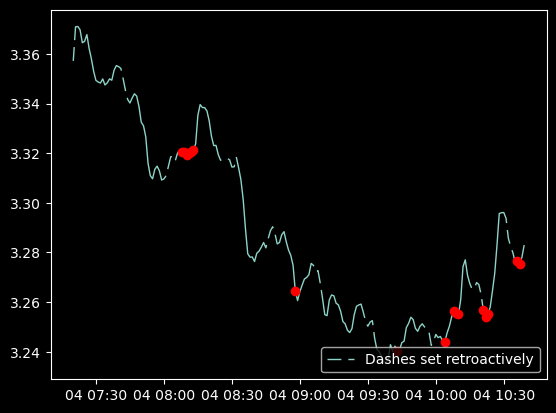

11207/11207 [==============================] - 35s 3ms/step
ModelAccuracy: 84.341%
True Win Predictions Mean of all: 2.078%
XXX Loss Buy Mean of all: 4.646%
Missed good deal off all: 11.013%
Good Zero prediction Mean: 82.263%
good fiability
========= Win Ratio:30.904223676383104 %====================


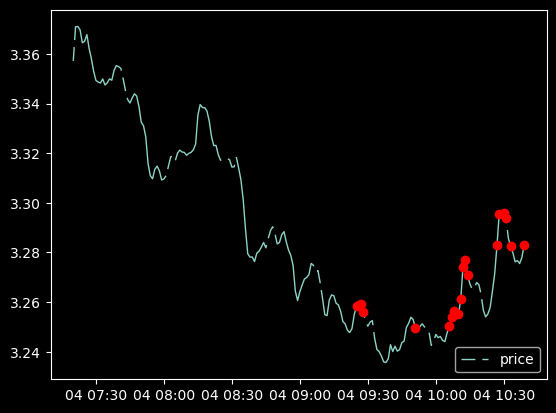

In [ ]:
## Generate Data
BAD_PERIOD_START="2022-08-30"
BAD_PERIOD_END="2022-11-22"
pair_to_test="GMT/USDT"
MAX_FORCAST_SIZE=5
USED_MODEL=very_deep_good_model#true_win_model#model_init #model_good_x3 #very_deep_good_model 16/1.7


loc_start=0
loc_end=1000000


i_start=71000
i_end=i_start+200

# loc_start=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_START))
# loc_end=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_END))


OnePair_DF=mini_expand5(        pair=pair_to_test,
                                i=loc_start,j=loc_end,
                                window=WINDOW_SIZE,
                                metadata=MetaData,
                                high_weight=1,
                                BUY_PCT=0.55,
                                SELL_PCT=SELL_PCT,
                                buy_function=buy_fix#buy_test
                        )
OnePair_DT=OnePair_DF.to_numpy()
gc.collect()
OnePair_DT=fixdt(OnePair_DT)
print(OnePair_DT[0,0] == OnePair_DF.iloc[0,0])
print(OnePair_DT[5,5] == OnePair_DF.iloc[5,5])
hp(OnePair_DF.buy.mean(),"Buy mean pct")

import matplotlib.pyplot as plt

x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off

fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='Dashes set retroactively')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()



OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
OnePair_Pred=OnePair_PredNote.round()

gc.collect()

Original_Traget_Data=OnePair_DT[:,-1]
Predicted_Data=OnePair_Pred[:,0]
gc.collect()
TruePred=(Original_Traget_Data==Predicted_Data).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
gc.collect()
TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
gc.collect()
LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
gc.collect()

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
gc.collect()

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
gc.collect()

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

print(f"========= Win Ratio:{winratio*100} %====================")




PREDICTION_TO_TEST=Predicted_Data

x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='price')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()


In [ ]:
XX=OnePair_DT[:100000,:-1]
YY=OnePair_DT[:100000,-1]
precision=0.0
# Good_Prediction_Note=very_deep_good_model.predict( XX)
# Bad_Prediction_Note=very_deep_bad_model.predict( XX)
# Initial_Pred_Note=model_init.predict( XX)
Predicted_Data=OnePair_Pred[:300000,0]
goodp=(Good_Prediction_Note-precision).round()
# badp=(Bad_Prediction_Note).round()
# initp=Initial_Pred_Note.round()

# Original_Traget_Data=YY

#Predicted_Data=((goodp==badp|initp==goodp))[:,0]
Predicted_Data=(goodp)[:,0]

GoodTruePred=(Original_Traget_Data==Predicted_Data).copy()
GoodModelAccuracy=hp(GoodTruePred.mean(),"ModelAccuracy")

GoodTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
GoodTrueWinPred_Mean=hp(GoodTrueWinPred.mean(),"True Win Predictions Mean of all")

GoodLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
GoodLossPred_Mean=hp(GoodLossPred.mean(),"XXX Loss Buy Mean of all")

GoodMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
GoodMissedDeal_Mean=hp(GoodMissedDealPred.mean(),"Missed good deal off all")

GoodGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodGoodZero_Mean=hp(GoodGoodZeroPred.mean(),"Good Zero prediction Mean")

winratio=GoodTrueWinPred_Mean/(GoodTrueWinPred_Mean+GoodLossPred_Mean)
fiability=GoodTrueWinPred_Mean + GoodLossPred_Mean + GoodMissedDeal_Mean + GoodGoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
print(f"========= Win Ratio:{winratio*100} ====================")


NameError: name 'Good_Prediction_Note' is not defined

In [ ]:
def test_prediction(XX,YY,USEDMODEL)
XX=OnePair_DT[:100000,:-1]
YY=OnePair_DT[:100000,-1]

# Good_Prediction_Note=very_deep_good_model.predict( XX)
# Bad_Prediction_Note=very_deep_bad_model.predict( XX)
# Initial_Pred_Note=model_init.predict( XX)
goodp=(Good_Prediction_Note-precision).round()
# badp=(Bad_Prediction_Note).round()
# initp=Initial_Pred_Note.round()

# Original_Traget_Data=YY

#Predicted_Data=((goodp==badp|initp==goodp))[:,0]
Predicted_Data=(goodp)[:,0]

GoodTruePred=(Original_Traget_Data==Predicted_Data).copy()
GoodModelAccuracy=hp(GoodTruePred.mean(),"ModelAccuracy")

GoodTrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
GoodTrueWinPred_Mean=hp(GoodTrueWinPred.mean(),"True Win Predictions Mean of all")

GoodLossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
GoodLossPred_Mean=hp(GoodLossPred.mean(),"XXX Loss Buy Mean of all")

GoodMissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
GoodMissedDeal_Mean=hp(GoodMissedDealPred.mean(),"Missed good deal off all")

GoodGoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodGoodZero_Mean=hp(GoodGoodZeroPred.mean(),"Good Zero prediction Mean")

winratio=GoodTrueWinPred_Mean/(GoodTrueWinPred_Mean+GoodLossPred_Mean)
fiability=GoodTrueWinPred_Mean + GoodLossPred_Mean + GoodMissedDeal_Mean + GoodGoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
print(f"========= Win Ratio:{winratio*100} ====================")
